# Check metrics

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.insert(0, "../code/")

In [3]:
from custom_ignite.metrics import ConfusionMatrix
from custom_ignite.metrics.confusion_matrix import output_gt_predicted_classes_bg

from sklearn.metrics import confusion_matrix

In [4]:
import numpy as np
import matplotlib.pylab as plt

%matplotlib inline

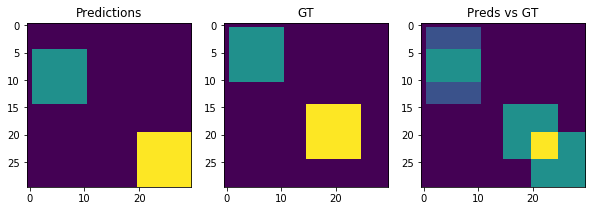

In [5]:
# 3 classes:
y_true = np.zeros((30, 30), dtype=np.int)
y_true[1:11, 1:11] = 1
y_true[15:25, 15:25] = 2


y_pred = np.zeros((30, 30), dtype=np.int)
y_pred[5:15, 1:11] = 1
y_pred[20:30, 20:30] = 2



plt.figure(figsize=(10, 5))
plt.subplot(131)
plt.title("Predictions")
plt.imshow(y_pred)
plt.subplot(132)
plt.title("GT")
plt.imshow(y_true)
plt.subplot(133)
plt.title("Preds vs GT")
plt.imshow(y_true + y_pred)

In [6]:
cm = confusion_matrix(y_true.reshape(-1), y_pred.reshape(-1))

In [7]:
cm

array([[585,  40,  75],
       [ 40,  60,   0],
       [ 75,   0,  25]])

In [8]:
((y_true * y_pred) == 1).sum()

60

In [9]:
((y_true * y_pred) == 4).sum()

25

In [10]:
import torch

In [11]:
m = ConfusionMatrix(num_classes=3, output_transform=output_gt_predicted_classes_bg)

In [12]:
th_y_true = torch.from_numpy(y_true).reshape(1, 30, 30)
th_y_true.shape

torch.Size([1, 30, 30])

In [13]:
y_probas = np.ones((2, 30, 30)) * -10
y_probas[0, (y_pred == 1)] = 720
y_probas[1, (y_pred == 2)] = 768

th_y_logits = torch.from_numpy(y_probas).reshape(1, 2, 30, 30)
th_y_logits.shape

torch.Size([1, 2, 30, 30])

In [14]:
output = m._output_transform((th_y_logits, th_y_true))
m.update(output)

In [15]:
m.compute()

tensor([[585.,  40.,  75.],
        [ 40.,  60.,   0.],
        [ 75.,   0.,  25.]])

In [16]:
conf_mat = ConfusionMatrix(num_classes=3, output_transform=output_gt_predicted_classes_bg)

In [17]:
th_y_true1 = torch.from_numpy(y_true).reshape(1, 30, 30)
th_y_true2 = torch.from_numpy(y_true.transpose()).reshape(1, 30, 30)
th_y_true = torch.cat([th_y_true1, th_y_true2], dim=0)
th_y_true.shape

torch.Size([2, 30, 30])

In [18]:
y_probas = np.ones((2, 30, 30)) * -10
y_probas[0, (y_pred == 1)] = 720
y_probas[1, (y_pred == 2)] = 768

th_y_logits1 = torch.from_numpy(y_probas).reshape(1, 2, 30, 30)


y_probas = np.ones((2, 30, 30)) * -10
y_probas[0, (y_pred.transpose() == 1)] = 720
y_probas[1, (y_pred.transpose() == 2)] = 768

th_y_logits2 = torch.from_numpy(y_probas).reshape(1, 2, 30, 30)

th_y_logits = torch.cat([th_y_logits1, th_y_logits2], dim=0)
th_y_logits.shape

torch.Size([2, 2, 30, 30])

In [28]:
output = conf_mat._output_transform((th_y_logits, th_y_true))
conf_mat.update(output)

In [29]:
res = conf_mat.compute()
res

tensor([[585.,  40.,  75.],
        [ 40.,  60.,   0.],
        [ 75.,   0.,  25.]])

IoU / Mean IoU

In [46]:
m = ConfusionMatrix(num_classes=3, output_transform=output_gt_predicted_classes_bg)

In [47]:
th_y_true = torch.from_numpy(y_true).reshape(1, 30, 30)
th_y_true.shape

torch.Size([1, 30, 30])

In [48]:
y_probas = np.ones((2, 30, 30)) * -10
y_probas[0, (y_pred == 1)] = 720
y_probas[1, (y_pred == 2)] = 768

th_y_logits = torch.from_numpy(y_probas).reshape(1, 2, 30, 30)
th_y_logits.shape

torch.Size([1, 2, 30, 30])

In [67]:
from ignite.metrics import MetricsLambda

IoU = MetricsLambda(lambda res: res[1:], (m.diag() / (m.sum(dim=1) + m.sum(dim=0) - m.diag())))
mIoU = IoU.mean()

In [68]:
output = m._output_transform((th_y_logits, th_y_true))
m.update(output)

In [69]:
IoU.compute(), mIoU.compute()

(tensor([0.4286, 0.1429]), tensor(0.2857))

In [62]:
m.compute()

tensor([[585.,  40.,  75.],
        [ 40.,  60.,   0.],
        [ 75.,   0.,  25.]])

## Check with model and evaluator

In [1]:
import sys

sys.path.insert(0, "../code/")
sys.path.insert(0, "../code/deeplab/")

In [2]:

import cv2
import torch
import torch.nn as nn
import torch.optim as optim

from albumentations import Compose, Resize, ShiftScaleRotate, GaussNoise
from albumentations import RandomBrightnessContrast, Normalize

from ignite.contrib.handlers import PiecewiseLinear

from dataflow.dataloaders import get_train_val_loaders
from dataflow.datasets import get_train_dataset
from dataflow.transforms import ToTensor, ignore_mask_boundaries, prepare_batch_fp16, prepare_batch_fp32

from models.deeplabv3 import DeepLabV3
from models.backbones import build_resnet18_backbone


seed = 12
device = 'cuda'
debug = True

use_fp16 = False


train_transforms = Compose([
    ShiftScaleRotate(shift_limit=0.2, scale_limit=0.075, rotate_limit=45, interpolation=cv2.INTER_CUBIC, p=0.3),
    Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    GaussNoise(),
    RandomBrightnessContrast(),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor(),
    ignore_mask_boundaries
])
train_transform_fn = lambda dp: train_transforms(**dp)


val_transforms = Compose([
    Resize(224, 224, interpolation=cv2.INTER_CUBIC),
    Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensor(),
    ignore_mask_boundaries
])
val_transform_fn = lambda dp: val_transforms(**dp)


batch_size = 64


train_loader, val_loader, train_eval_loader = get_train_val_loaders(root_path="/home/storage_ext4_1tb/", 
                                                                    train_transforms=train_transform_fn,
                                                                    val_transforms=val_transform_fn,
                                                                    batch_size=batch_size,
                                                                    val_batch_size=batch_size * 2,
                                                                    random_seed=12)

prepare_batch = prepare_batch_fp16 if use_fp16 else prepare_batch_fp32


num_classes = 21
model = DeepLabV3(build_resnet18_backbone, num_classes=num_classes)


criterion = nn.CrossEntropyLoss()

lr = 0.001
weight_decay = 1e-4

optimizer = optim.ASGD(model.parameters(), 
                       lr=lr / batch_size,                       
                       weight_decay=weight_decay * batch_size)

num_epochs = 50


lr_scheduler = PiecewiseLinear(optimizer, 
                               param_name="lr",
                               milestones_values=[(0, 0), (5, lr), (35, lr), (35, lr * 0.1)])


def score_function(evaluator):
    score = evaluator.state.metrics['mIoU']
    return score


In [17]:
dp = train_loader.dataset[0]

In [20]:
res = train_loader.collate_fn([dp, ])
res['image'].shape

torch.Size([1, 3, 224, 224])

In [3]:
from custom_ignite.metrics import IoU, mIoU
from custom_ignite.metrics.confusion_matrix import output_gt_predicted_classes
from ignite.engine import Engine, create_supervised_evaluator, Events

In [4]:
from custom_ignite.metrics import ConfusionMatrix


val_metrics = {
    "CM": ConfusionMatrix(num_classes=num_classes, output_transform=output_gt_predicted_classes)
#     "IoU": IoU(num_classes=num_classes, output_transform=output_gt_predicted_classes),
#     "mIoU": mIoU(num_classes=num_classes, output_transform=output_gt_predicted_classes),
}
evaluator = create_supervised_evaluator(model, val_metrics,
                                        prepare_batch=prepare_batch,
                                        device=device, non_blocking=True)


In [5]:
len(evaluator.state.output), evaluator.state.output[0].shape, evaluator.state.output[1].shape

AttributeError: 'NoneType' object has no attribute 'output'

In [9]:
cm = val_metrics['CM']
cm.iteration_completed??

Signature: cm.iteration_completed(engine)
Docstring: <no docstring>
Source:   
    @torch.no_grad()
    def iteration_completed(self, engine):
        output = self._output_transform(engine.state.output)
        self.update(output)
File:      /usr/local/lib/python3.5/dist-packages/ignite/metrics/metric.py
Type:      method


In [11]:
output = cm._output_transform(evaluator.state.output)
len(output), output[0].shape, output[1].shape

AttributeError: 'tuple' object has no attribute 'shape'

In [16]:
type(output), type(output[0]), len(output[0])

(tuple, tuple, 2)

In [8]:
cm.iteration_completed(evaluator)

AttributeError: 'tuple' object has no attribute 'ndimension'

In [5]:
evaluator.run(train_eval_loader)

AttributeError: 'tuple' object has no attribute 'ndimension'

In [3]:
from torch.utils.data.dataloader import DataLoader, default_collate

In [4]:
default_collate??

Signature: default_collate(batch)
Source:   
def default_collate(batch):
    r"""Puts each data field into a tensor with outer dimension batch size"""

    error_msg = "batch must contain tensors, numbers, dicts or lists; found {}"
    elem_type = type(batch[0])
    if isinstance(batch[0], torch.Tensor):
        out = None
        if _use_shared_memory:
            # If we're in a background process, concatenate directly into a
            # shared memory tensor to avoid an extra copy
            numel = sum([x.numel() for x in batch])
            storage = batch[0].storage()._new_shared(numel)
            out = batch[0].new(storage)
        return torch.stack(batch, 0, out=out)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' \
            and elem_type.__name__ != 'string_':
        elem = batch[0]
        if elem_type.__name__ == 'ndarray':
            # array of string classes and object
            if re.search('[SaUO]', elem.dtype.str) is not None:
      